
=== sklearn (TotalHours only) ===


,Degree,Features↑,R² (train),R² (test),RMSE (train),RMSE (test),MAE (test)
0,1,1,0.9232,0.8602,4.8076,5.6909,5.0831
1,2,2,0.9232,0.8635,4.8048,5.6232,5.0345
2,3,3,0.9237,0.8659,4.7921,5.5742,4.9951


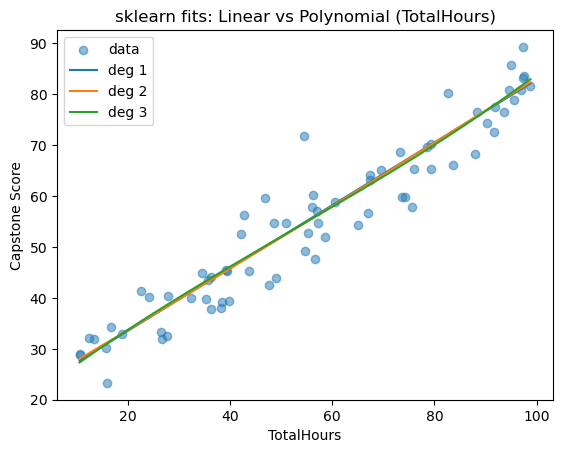

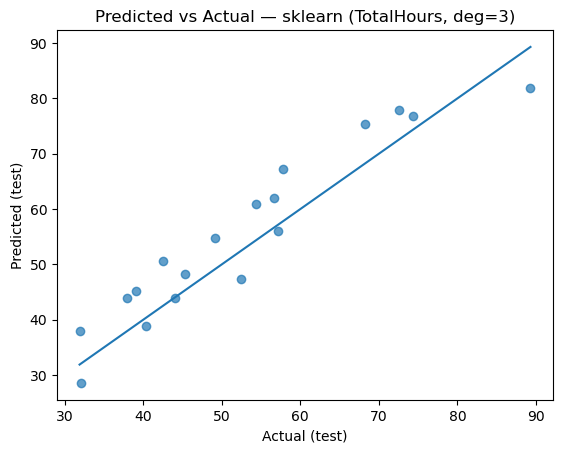

In [9]:
# === Scikit-learn comparison: One-feature Linear & Polynomial (TotalHours → CapstoneScore) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Feature and target
X = df[["TotalHours"]].astype(float).values
y = df["CapstoneScore"].astype(float).values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

def make_pipeline(degree: int):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),  # degree=1 -> linear
        ("linreg", LinearRegression())
    ])

def eval_model(degree: int):
    pipe = make_pipeline(degree)
    pipe.fit(X_train, y_train)
    yhat_train = pipe.predict(X_train)
    yhat_test  = pipe.predict(X_test)

    mse  = mean_squared_error
    rmse = lambda a,b: np.sqrt(mean_squared_error(a,b))
    mae  = mean_absolute_error

    return {
        "degree": degree,
        "n_features": pipe.named_steps["poly"].n_output_features_,
        "R2_train": r2_score(y_train, yhat_train),
        "R2_test":  r2_score(y_test,  yhat_test),
        "RMSE_train": rmse(y_train, yhat_train),
        "RMSE_test":  rmse(y_test,  yhat_test),
        "MAE_test": mae(y_test, yhat_test),
        "model": pipe,
        "yhat_test": yhat_test
    }

# Run for linear (deg=1) and poly (deg=2,3)
results_sklearn = [eval_model(d) for d in [1,2,3]]

# Benchmark table
bench = pd.DataFrame([{
    "Degree": r["degree"],
    "Features↑": r["n_features"],
    "R² (train)": r["R2_train"],
    "R² (test)":  r["R2_test"],
    "RMSE (train)": r["RMSE_train"],
    "RMSE (test)":  r["RMSE_test"],
    "MAE (test)":  r["MAE_test"],
} for r in results_sklearn]).sort_values("Degree")

print("\n=== sklearn (TotalHours only) ===")
try:
    display(bench.style.format({c:"{:.4f}" for c in bench.columns if "R" in c or "M" in c}))
except Exception:
    print(bench.to_string(index=False))

# --- Curve plot: show fits for deg 1,2,3 on same scatter ---
xx = np.linspace(X.min(), X.max(), 200).reshape(-1,1)

plt.scatter(X, y, alpha=0.5, label="data")
for r in results_sklearn:
    yy = r["model"].predict(xx)
    plt.plot(xx, yy, label=f"deg {r['degree']}")
plt.xlabel("TotalHours")
plt.ylabel("Capstone Score")
plt.title("sklearn fits: Linear vs Polynomial (TotalHours)")
plt.legend(); plt.show()

# --- Predicted vs Actual for best test R² ---
best = max(results_sklearn, key=lambda r: r["R2_test"])
plt.scatter(y_test, best["yhat_test"], alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel("Actual (test)")
plt.ylabel("Predicted (test)")
plt.title(f"Predicted vs Actual — sklearn (TotalHours, deg={best['degree']})")
plt.show()


scikit‑learn Linear vs Polynomial (full dataset)

In [5]:
# === Scikit‑learn baseline & benchmarking: Linear vs Polynomial (full dataset) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


=== scikit‑learn Linear vs Polynomial (full dataset) ===


,Degree,Features↑,R² (train),R² (test),RMSE (train),RMSE (test),Fit time (s),Predict time (s)
0,1,5,0.9293,0.8776,4.6114,5.3256,0.0019,0.001291
1,2,20,0.9430,0.8147,4.1411,6.5511,0.0021,0.001743
2,3,55,0.9969,-7.3594,0.9657,44.0036,0.0033,0.001788



Best model by R²(test): degree=1  features=5

Top negative coefficients (standardized space):
          HackathonParticipation : -0.205015
            AssignmentsCompleted : -0.128604
                      Attendance :  0.027662
                 PeerReviewScore :  1.328791
                      TotalHours :  16.645957

Top positive coefficients (standardized space):
          HackathonParticipation : -0.205015
            AssignmentsCompleted : -0.128604
                      Attendance :  0.027662
                 PeerReviewScore :  1.328791
                      TotalHours :  16.645957


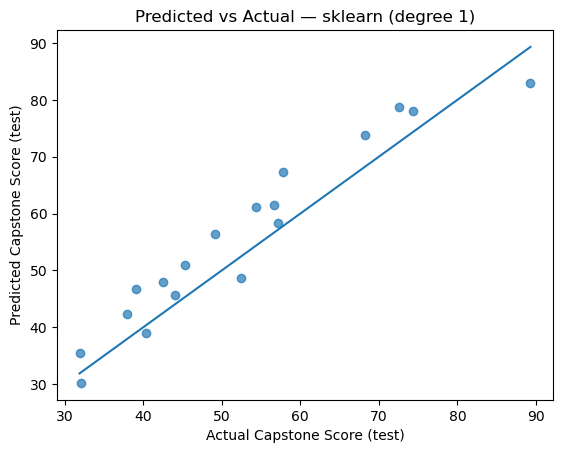

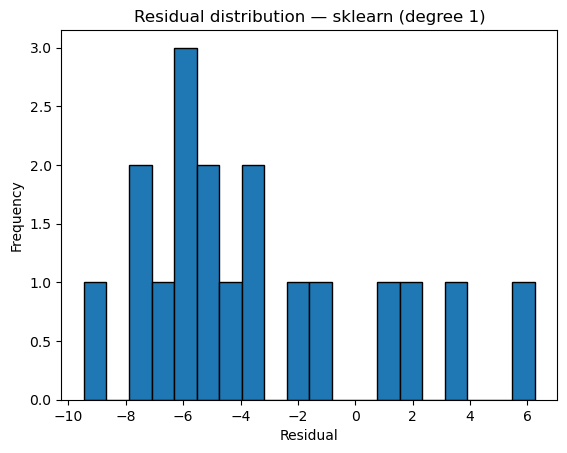

In [6]:


# ---------- Load & filter ----------
df = pd.read_csv("zuu crew scores.csv").copy()
df = df[df["CourseName"] == "Foundations of ML"].reset_index(drop=True)

FEATURES = ["Attendance", "TotalHours", "AssignmentsCompleted",
            "HackathonParticipation", "PeerReviewScore"]  # or swap PeerReviewScore -> GitHubScore
TARGET = "CapstoneScore"

X = df[FEATURES].astype(float).values
y = df[TARGET].astype(float).values

# ---------- Train/test split (fit scalers on train only) ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

def make_pipeline(degree: int) -> Pipeline:
    # include_bias=False so LinearRegression handles the intercept
    return Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("linreg", LinearRegression())
    ])

def evaluate_model(degree: int):
    pipe = make_pipeline(degree)
    t0 = perf_counter()
    pipe.fit(X_train, y_train)
    fit_secs = perf_counter() - t0

    t1 = perf_counter()
    yhat_train = pipe.predict(X_train)
    yhat_test = pipe.predict(X_test)
    pred_secs = perf_counter() - t1

    # Metrics
    def mse(a,b): return mean_squared_error(a,b)
    def rmse(a,b): return np.sqrt(mean_squared_error(a, b))
    def mae(a,b): return mean_absolute_error(a,b)
    
    metrics = {
        "degree": degree,
        "n_features_after_expansion": pipe.named_steps["poly"].n_output_features_,
        "fit_time_s": fit_secs,
        "pred_time_s": pred_secs,
        "R2_train": r2_score(y_train, yhat_train),
        "R2_test":  r2_score(y_test,  yhat_test),
        "RMSE_train": rmse(y_train, yhat_train),
        "RMSE_test":  rmse(y_test,  yhat_test),
        "MSE_train": mse(y_train, yhat_train),
        "MSE_test":  mse(y_test,  yhat_test),
        "MAE_train": mae(y_train, yhat_train),
        "MAE_test":  mae(y_test,  yhat_test),
        "pipe": pipe,
        "yhat_test": yhat_test
    }
    return metrics

results = [evaluate_model(d) for d in [1,2,3]]

# ---------- Benchmark table ----------
bench = pd.DataFrame([{
    "Degree": r["degree"],
    "Features↑": r["n_features_after_expansion"],
    "R² (train)": r["R2_train"],
    "R² (test)":  r["R2_test"],
    "RMSE (train)": r["RMSE_train"],
    "RMSE (test)":  r["RMSE_test"],
    "Fit time (s)": r["fit_time_s"],
    "Predict time (s)": r["pred_time_s"],
} for r in results]).sort_values("Degree")
print("\n=== scikit‑learn Linear vs Polynomial (full dataset) ===")
display(bench.style.format({
    "R² (train)": "{:.4f}", "R² (test)": "{:.4f}",
    "RMSE (train)": "{:.4f}", "RMSE (test)": "{:.4f}",
    "Fit time (s)": "{:.4f}", "Predict time (s)": "{:.6f}"
}))

# ---------- Parameter comparison analysis (coefficient inspection) ----------
def top_coeffs(result, top_k=10):
    pipe = result["pipe"]
    poly = pipe.named_steps["poly"]
    lr   = pipe.named_steps["linreg"]
    feature_names = poly.get_feature_names_out(FEATURES)  # after scaling+poly (no bias)
    coefs = lr.coef_                                   # shape: [n_features_after_expansion]
    # Pair names & coefficients; show both largest + and most negative
    order = np.argsort(coefs)
    lowest = list(zip(feature_names[order[:top_k]], coefs[order[:top_k]]))
    highest = list(zip(feature_names[order[-top_k:]], coefs[order[-top_k:]]))
    return lowest, highest

# Pick the best model by test R²
best = max(results, key=lambda r: r["R2_test"])
lowest, highest = top_coeffs(best, top_k=8)

print(f"\nBest model by R²(test): degree={best['degree']}  "
      f"features={best['n_features_after_expansion']}")
print("\nTop negative coefficients (standardized space):")
for name, val in lowest:
    print(f"  {name:>30} : {val: .6f}")
print("\nTop positive coefficients (standardized space):")
for name, val in highest:
    print(f"  {name:>30} : {val: .6f}")

# ---------- Visual checks for best model ----------
import matplotlib.pyplot as plt

y_pred_best = best["yhat_test"]
plt.figure()
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel("Actual Capstone Score (test)")
plt.ylabel("Predicted Capstone Score (test)")
plt.title(f"Predicted vs Actual — sklearn (degree {best['degree']})")
plt.show()

residuals = y_test - y_pred_best
plt.figure()
plt.hist(residuals, bins=20, edgecolor="black")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title(f"Residual distribution — sklearn (degree {best['degree']})")
plt.show()
